# Data Release Example Scripts: GP Flux Measurement

This notebooks illustrates how the Galactic Plane analysis can be reproduced with the provided data release.

## Import necessary python libraries

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats, optimize
from scipy.interpolate import UnivariateSpline
import healpy as hp

## Define some global settings

In [2]:

# directory that contains the data release files
data_dir = './'


## Load event-level data from data release

The event-level data contains the contributions to each of the likelihood-ratio terms and it is provided via csv files. We will load these via the python library pandas.

In [3]:

df_events = pd.read_csv(os.path.join(data_dir, 'event_contributions_gp.csv'))
df_events

,index,pi0_SoB_space,pi0_SoB_space_ss,pi0_SoB_energy,kra5_SoB_space,kra5_SoB_space_ss,kra5_SoB_energy,kra50_SoB_space,kra50_SoB_space_ss,kra50_SoB_energy,energy
0,0,0.692519,0.860233,0.500933,0.753545,0.701928,0.368401,0.755185,0.689519,0.340799,511.04470
1,1,0.958882,0.576717,1.250469,0.481027,0.606638,1.192750,0.468408,0.606757,1.107383,3056.11620
2,2,2.006834,0.915553,0.637734,3.413523,1.116882,0.480000,3.498774,1.133913,0.431011,1205.61720
3,3,0.534618,0.569958,0.477011,0.313111,0.612733,0.336891,0.303210,0.614799,0.303042,543.12555
4,4,0.863574,1.046434,0.758145,1.212052,1.459628,0.621432,1.232023,1.491399,0.560319,1520.57900
...,...,...,...,...,...,...,...,...,...,...,...
59587,59587,2.037703,1.432772,0.713608,1.039472,0.827052,0.542727,0.980716,0.780132,0.512550,899.31586
59588,59588,0.520954,0.755350,1.522805,0.453037,0.856273,1.528641,0.452743,0.863240,1.426141,4025.70950
59589,59589,0.313287,0.920612,0.560882,0.218936,0.677455,0.370636,0.214112,0.659053,0.343972,641.50380
59590,59590,1.456440,0.680659,1.233844,1.409097,0.484568,1.219044,1.378466,0.468063,1.151479,2471.36130


## Define Likelihood-ratio and optimization functions

As stated in the paper, the "signal-subtracted" likelihood is given by:

\begin{equation}
 \mathcal{L} (n_s, \gamma) = \prod_{i=1}^N \frac{n_s}{N} S_i(\gamma, \delta_i, \alpha_i, \sigma_i, E_i) + \tilde{D_i} (\delta_i, E_i) - \frac{n_s}{N}\tilde{S_i} (\delta_i, E_i) 
    \label{eq:ssllh}
\end{equation}

with the PDF $\tilde{D}$ obtained from the scrambled experimental data and 
$\tilde{S}$ the scrambled signal PDF as obtained from MC.

The test-statistic (TS) is defined by the ratio of the maximized likelihood and the likelihood for the null hypothesis:

\begin{equation}
TS = -2 \ln \frac{ \mathcal{L} (n_s = 0)}{ \mathcal{L}(\hat{n}_s,\gamma)}
    \label{eq:TS}
\end{equation}

Inserting the definitions for the likelihood in the above TS equation (and omitting the function arguments) results in

\begin{equation}
TS(n_s) = -2 \ln \frac{
        \prod_{i=1}^N \frac{n_s}{N} S_i + \tilde{D_i} - \frac{n_s}{N}\tilde{S_i}
    }{ 
       \prod_{i=1}^N \tilde{D_i}
    }
   = -2 \ln \prod_{i=1}^N  \left( \frac{n_s}{N} \cdot 
        \frac{S_i -\tilde{S_i}}{\tilde{D_i}}
    + 1
    \right)
   = -2 \sum_{i=1}^N \ln \left( \frac{n_s}{N} \cdot 
        \frac{S_i -\tilde{S_i}}{\tilde{D_i}}
    + 1
    \right)
\end{equation}

Directly optimizing the test-statistic as a function of $n_s$ is equivalent to first optimizing the likelihood $\mathcal L (n_s)$ and subsquently computing the test-statistic. The analysis software directly optimizes the test-statistic as a function of $n_s$. This has the added benefit that individual analysis PDFs for signal and background only need to be defined as ratios.
Furthermore, the PDFs can be split up into an energy and spacial term. We can therefore also write:

\begin{equation}
TS(n_s) 
   = -2 \sum_{i=1}^N \ln \left( \frac{n_s}{N} \cdot 
        \left(
            \frac{S_i^\mathrm{space}}{\tilde{D_i}^\mathrm{space}}
            - \frac{\tilde{S_i}^\mathrm{space}}{\tilde{D_i}^\mathrm{space}}
        \right) \cdot 
        \frac{S_i^\mathrm{energy}}{\tilde{D_i}^\mathrm{energy}}
    + 1
    \right)
   %= -2 \sum_{i=1}^N \ln \left( \frac{n_s}{N} \cdot 
   %     \frac{\left(S_i^\mathrm{space} -\tilde{S_i}^\mathrm{space}\right) \cdot S_i^\mathrm{energy}}{\tilde{D_i}^\mathrm{space}\cdot\tilde{D_i}^\mathrm{energy}}
   % + 1
   % \right)
\end{equation}


Here we used the fact that the signal energy PDF remains the same for scrambled and un-scrambled events, e.g. $S_i^\mathrm{energy}$ = $\tilde{S_i}^\mathrm{energy}$.

The individual ratio terms for each event are provided in the data release. In terms of the column names in the data file, this results in :


\begin{equation}
TS(n_s) 
   = -2 \sum_{i=1}^N \ln \left( \frac{n_s}{N} \cdot 
        \left(
            \mathrm{SoB\_space}_i
            - \mathrm{SoB\_space\_ss}_i
        \right) \cdot 
        \mathrm{SoB\_energy}_i
    + 1
    \right)
\end{equation}

We will use this equation to define the python function `get_test_statistic`.

In [4]:

def get_test_statistic(ns, N, SoB_space, SoB_space_ss, SoB_energy):
    """Compute test-statistic
    
    Parameters
    ----------
    ns : float
        The number of signal events.
    N : int
        The total number of events.
    SoB_space : array_like
        The ratio of the signal and background space PDF.
    SoB_space_ss : array_like
        The ratio of the scrambled signal and background space PDF.
    SoB_energy : array_like
        The ratio of the signal and background energy PDF.
    
    Returns
    -------
    float
        The test-statistic of the maximized likelihood ratio.
    """
    ts = np.sum(2*np.log((SoB_space - SoB_space_ss) * SoB_energy * ns/N + 1))
    return ts


We can now optimize the test-statistic. We will use scipy for the optimization and we will loop through each of the GP models. The best fit $\hat{n}_s$ is then saved in the dictionary `res_dict`.

In [5]:
# define the function we need to minimize
def get_negative_test_statistic(*args, **kwargs):
    return -get_test_statistic(*args, **kwargs)

# define a dictionary which will hold our results
res_dict = {}

# loop through each GP model
for key in ['pi0', 'kra5', 'kra50']:
    
    # Minimize negative test-statistic function via scipy
    print('Now optimizing the test-statistic for the GP model {}'.format(key))
    result = optimize.minimize(
        get_negative_test_statistic, 
        x0=0, 
        args=(
            len(df_events),  # N
            df_events[key + '_SoB_space'],  # SoB_space
            df_events[key + '_SoB_space_ss'],  # SoB_space_ss
            df_events[key + '_SoB_energy'],  # SoB_energy
        ),
    )
    
    # save fitted ns and ts to the dictionary
    res_dict[key] = {
        'ns': result.x[0],
        'ts': -result.fun,
    } 
    print('  ns: {:3.1f} | ts: {:3.2f}'.format(result.x[0], -result.fun))


Now optimizing the test-statistic for the GP model pi0
  ns: 748.0 | ts: 22.19
Now optimizing the test-statistic for the GP model kra5
  ns: 275.6 | ts: 19.06
Now optimizing the test-statistic for the GP model kra50
  ns: 211.1 | ts: 15.56


## Compute Significance

In order to compute the significance of rejecting the null-hypothesis, we need to compare the computed test-statistic value against background trials. Background trials are obtained by randomizing the experimental data by scrambling the right ascension value of the events. 
The test-statistic distribution of the background trials is provided in the data release via two files that define the bin edges and the bin heights of each bin.

In [6]:
df_bins = pd.read_csv(os.path.join(data_dir, 'bkg_trials_binning.csv'))
df_values = pd.read_csv(os.path.join(data_dir, 'bkg_trials_values.csv'))
df_values

,index,pi0,kra5,kra50
0,0,316973706.0,174734016.0,175800481.0
1,1,16509727.0,8953442.0,8880106.0
2,2,12450456.0,6735098.0,6683222.0
3,3,10305112.0,5575316.0,5532254.0
4,4,8921708.0,4824938.0,4782183.0
...,...,...,...,...
995,995,0.0,0.0,0.0
996,996,0.0,0.0,0.0
997,997,0.0,0.0,0.0
998,998,0.0,0.0,0.0


The function `get_significance_from_hist` computes the significance to reject the null-hypothesis for a given test-statistic value by evaluating the fraction of background trials with an equally large or larger test-statist value. This fraction corresponds to the probability of falsely rejecting the null-hypothesis and is therefore considered as the `p-value`. We can then convert the p-value to "multiples of sigma" by checking what number of standard deviations such a p-value would correspond to for a normal distribution.

In [7]:
def get_significance_from_hist(ts, bin_edges, bin_values):
    """Compute significance for a given test-statistic
    
    Parameters
    ----------
    ts : float
        The test-statistic value for which the significance will be calculated.
    bin_edges : array_like
        The bin edges for the background trial histogram.
    bin_values : array_like
        The bin heights for the background trial histogram.
    
    Returns
    -------
    float
        The significance of rejecting the null hypothesis for the given
        test-statistic value based on the background trials provided
        via `bin_edges` and `bin_values`
    """
    # get index for which is valid:
    # edge[i-1] < ts <= edge[i]
    # this correspdonds to the i-th entry in bin_values
    index = np.searchsorted(bin_edges, ts)
    
    # get number of trials with larger ts values
    n_larger = np.sum(bin_values[index:])
    pval = 1.*n_larger/np.sum(bin_values)
    nsigma = stats.norm.isf(pval)
    
    return pval, nsigma

Now we will compute the significance for each of the tested GP models:

In [8]:
for key in ['pi0', 'kra5', 'kra50']:
    pval, nsigma = get_significance_from_hist(
        ts=res_dict[key]['ts'],
        bin_edges=df_bins[key].values,
        bin_values=df_values[key].values,
    )
    res_dict[key]['nsigma'] = nsigma
    print('{:3.2f} sigma | GP model: {}'.format(nsigma, key))

4.71 sigma | GP model: pi0
4.37 sigma | GP model: kra5
3.96 sigma | GP model: kra50


## Convert $\hat{n}_s$ to Flux

In order to compute the flux for each of the GP models, the fitted number of signal events needs to be converted by utilizing the effective area of the event sample.

We'll start by loading the effective area, which is provided as a 2D array with the first axis in sin(dec) and the second axis in energy (units of GeV). The binning edges are provided in separate files.

In [9]:
effa_values = np.loadtxt(os.path.join(data_dir, 'effa_values.csv'), delimiter=',')
print('Shape of 2D effective area:', effa_values.shape)

effa_bins_sindec = np.loadtxt(os.path.join(data_dir, 'effa_bins_sindec.csv'), delimiter=',')
print('Number of provided bin edges in sin(dec):', len(effa_bins_sindec))

effa_bins_energy = np.loadtxt(os.path.join(data_dir, 'effa_bins_energy.csv'), delimiter=',')
print('Number of provided bin edges in energy:', len(effa_bins_energy))


Shape of 2D effective area: (5, 120)
Number of provided bin edges in sin(dec): 6
Number of provided bin edges in energy: 121


In addition to the effective area, the galactic plane templates are also required. The KRA-$\gamma$ templates are provided on zenodo at this location: https://zenodo.org/record/7070823 and the $\pi^0$ is located here: https://galprop.stanford.edu/PaperIISuppMaterial/SS_Z4_R20_T150_C5.tar .
If downloaded from the provided links and placed in the defined `data_dir`, these can be loaded via:

In [10]:
template_kra5, template_kra5_nu, template_kra5_nubar, template_ebins5 = np.load(
    os.path.join(data_dir, 'KRA-gamma_5PeV_maps_energies.tuple.npy'), 
    allow_pickle = True, 
    encoding='latin1',
)
template_kra50, template_kra50_nu, template_kra50_nubar, template_ebins50 = np.load(
    os.path.join(data_dir, 'KRA-gamma_maps_energies.tuple.npy'), 
    allow_pickle = True, 
    encoding='latin1',
)
template_pi0 = np.load(
    os.path.join(data_dir, 'Fermi-LAT_pi0_map.npy'), 
    allow_pickle=True, 
    encoding='latin1',
)


In [11]:
# the provided KRA-gamma files do not provide the uppermost bin edge.
# We will add it here (each edge is 10% higher than the last):
template_ebins5_ext = np.r_[template_ebins5, template_ebins5[-1] * 1.1]
template_ebins50_ext = np.r_[template_ebins50, template_ebins50[-1] * 1.1]

#### Acceptance Correction for $\pi^0$ model

The $\pi^0$ template is provided as a healpix map normalized over the sky. The units are $\mathrm{sr}^-1$. The flux at each pixel is then simply the sky-integrated power-law flux multiplied by this spatial PDF. When combined with the effective area, the total number of expected events (`total_acceptance`) can be computed for a given reference normalization. The ratio to the number of observed signal events is then used to convert to a flux. This conversion is outlined in the function `acceptance_correct_pi0`.

In [12]:
def acceptance_correct_pi0(
            ns, template, eff_area, sindec_bins, energy_bins,
            livetime=304047105.0735066,
        ):
    """Convert a number of signal events to the corresponding flux

    Parameters
    ----------
    ns : array_like
        The number of signal events that will be converted to the
        corresponding flux.
    template : array_like
        The spatial template in units of sr^-1.
        Shape: [npix]
    eff_area : array_like
        The effective area binned in sin(dec) (unitless) along first
        dimension and and in energy (in GeV) along the second axis.
        shape: [n_bins_sindec, n_bins_energy]
    sindec_bins : array_like
        The bin edges along the first dimension corresponding to sin(dec).
        Shape: [n_bins_sindec + 1]
    energy_bins : TYPE
        The bin edges along the second dimension corresponding to
        the energy in GeV.
        Shape: [n_bins_energy + 1]
    livetime : float
        The livetime of the dataset in seconds.
        For the 10-year cascade dataset, the livetime corresponds to
        304047105.0735066 seconds, which is the default value.

    Returns
    -------
    array_like
        The flux in terms of E^2 dN/dE at 100 TeV in units
        of TeV cm^-2 s^-1.
    """

    npix = len(template)
    nside = hp.npix2nside(npix)
    
    # First we need to construct Phi(sindec, energy)
    # in units of GeV^-1 cm^-2 s^-1 sr^-1.
    # We will do this by splitting Phi into the spatial term (units of sr^-1)
    # and the energy term (units of GeV^-1 cm^-2 s^-1).
    # We can do this splitting for the pi0 model because the energy spectrum
    # is assumed not to depend on the location in the sky
    theta, phi = hp.pix2ang(nside, np.r_[:npix])
    pix_dec = np.pi/2. - theta
    pix_ra = phi
    pix_sindec = np.sin(pix_dec)

    # Phi(sindec), shape: [n_sindec], units of sr^-1
    phi_sindec = np.zeros(len(sindec_bins)-1)

    # walk through each declination band
    for i, sindec_max in enumerate(sindec_bins[1:]):
        sindec_min = sindec_bins[i]

        # get all pixels belonging to this dec band
        mask_pixels = np.logical_and(
            pix_sindec >= sindec_min,
            pix_sindec < sindec_max,
        )
        phi_sindec[i] = np.sum(template[mask_pixels])

    # Sky-integrated, per-flavor (nu + nubar) flux
    # Choose an arbitrary flux normalization to scale
    norm = 1e-18  # in units of GeV^-1 cm^-2 s^-1
    e0 = 1e5  # 100 TeV in units of GeV
    gamma = 2.7

    # compute average energy in each energy bin
    energy_avg = (
        (-gamma + 1) / (-gamma + 2) *
        (energy_bins[1:]**(-gamma+2) - energy_bins[:-1]**(-gamma+2)) /
        (energy_bins[1:]**(-gamma+1) - energy_bins[:-1]**(-gamma+1))
    )

    # Phi(energy) in units of GeV^-1 cm^-2 s^-1
    # shape: [n_energy]
    phi_e = norm * (energy_avg / e0) ** (-gamma)

    # Phi(sindec, energy)
    # shape: [n_sindec, n_energy],  GeV^-1 cm^-2 s^-1 sr^-1
    phi = phi_e[np.newaxis] * phi_sindec[:, np.newaxis]

    # "integrate" over energy bin width
    # shape: [n_sindec, n_energy], cm^-2 s^-1 sr^-1
    phi *= np.diff(energy_bins)[np.newaxis]

    # "integrate" over solid angle
    # shape: [n_pix, n_bins], s^-1 * cm^-2
    phi *= hp.nside2pixarea(nside)

    # Now we can compute the total number of expected events
    # for the given flux.
    # eff_area is in units of cm^2 and livetime in units of s
    total_acceptance = livetime * np.sum(eff_area * phi)

    # we can then compute the ratio of the number of signal events versus
    # the number of events one would have expected based on the previously
    # defined flux. This can then be used to scale the arbitrary flux
    # normalization that we chose as a reference point.
    model_norm = ns / total_acceptance

    # compute E^2 dN/dE at 100 TeV in units of TeV cm^-2 s^-1
    norm_tev = norm * 1e3  # in units of TeV^-1 cm^-2 s^-1
    norm_E2_tev = norm_tev * (100)**2
    return model_norm*norm_E2_tev

#### Acceptance Correction for KRA-$\gamma$ models

Similarly to the acceptance correction for the $\pi^0$ model, we can define this for the KRA-$\gamma$ models. 
The main difference here is that the model templates are already provided in bins over the sky and energy range in units of $\mathrm{GeV}^{-1} \cdot \mathrm{sr}^{-1} \cdot \mathrm{s}^{-1} \cdot \mathrm{cm}^{-2}$. 
These templates need to essentially be rebinned to the bins as defined in the effective area parameterization.
The remainder of the calculation is analogous to the acceptance correction of the $\pi^0$ model.

In [13]:
def acceptance_correct_kra(
            ns, template, template_e_bin_edges, eff_area, sindec_bins, energy_bins,
            livetime=304047105.0735066,
        ):
    """Convert a number of signal events to the corresponding model flux
    of the KRA-gamma templates

    Parameters
    ----------
    ns : array_like
        The number of signal events that will be converted to the
        corresponding flux.
    template : array_like
        The model template binned over the sky and energy range in units
        of GeV^-1 * sr^-1 * s^-1 * cm^-2.
        Shape: [n_pix, n_bins]
    template_e_bin_edges : array_like
        The bin edges that define the energy bins of the model template.
        Shape: [n_bins + 1]
    eff_area : array_like
        The effective area binned in sin(dec) (unitless) along first
        dimension and and in energy (in GeV) along the second axis.
        shape: [n_bins_sindec, n_bins_energy]
    sindec_bins : array_like
        The bin edges along the first dimension corresponding to sin(dec).
        Shape: [n_bins_sindec + 1]
    energy_bins : TYPE
        The bin edges along the second dimension corresponding to
        the energy in GeV.
        Shape: [n_bins_energy + 1]
    livetime : float
        The livetime of the dataset in seconds.
        For the 10-year cascade dataset, the livetime corresponds to
        304047105.0735066 seconds, which is the default value.

    Returns
    -------
    array_like
        The flux in terms of multiplies of the model prediction.
    """
    npix = len(template)
    nside = hp.npix2nside(npix)
    pixarea = hp.nside2pixarea(nside)

    assert len(template_e_bin_edges) == len(template[0]) + 1

    # compute energy bin widths
    t_delta_e = np.diff(template_e_bin_edges)

    # compute Phi(sindec, energy)
    theta, phi = hp.pix2ang(nside, np.r_[:npix])
    pix_dec = np.pi/2. - theta
    pix_ra = phi
    pix_sindec = np.sin(pix_dec)

    # Phi(sindec, energy), shape: [n_sindec, n_energy]
    phi = np.zeros((len(sindec_bins)-1, len(energy_bins) - 1))

    for i, sindec_max in enumerate(sindec_bins[1:]):
        sindec_min = sindec_bins[i]

        # get all pixels belonging to this dec band
        mask_pixels = np.logical_and(
            pix_sindec >= sindec_min,
            pix_sindec < sindec_max,
        )

        # select bins corresponding to this dec band
        template_decband = template[mask_pixels]

        for j, energy_max in enumerate(energy_bins[1:]):
            energy_min = energy_bins[j]

            # get all bins belonging to this energy band
            # we'll count a template energy bin to belong to the energy band
            # if the lower, left bin edge is within the energy band.
            # The upper, right bin edge is allowed to extend the energy band.
            # With this definition, we ensure that all template bins end up
            # being counted in one of the defined energy bands.
            mask_bins = np.logical_and(
                template_e_bin_edges[:-1] >= energy_min,
                template_e_bin_edges[:-1] < energy_max,
            )

            # Template files are in GeV^-1 * sr^-1 * s^-1 * cm^-2
            # shape: [n_pix, n_bins], GeV^-1 * sr^-1 * s^-1 * cm^-2
            flux_bins = template_decband[:, mask_bins]

            # "integrate" over energy range
            # shape: [n_pix, n_bins], sr^-1 * s^-1 * cm^-2
            flux_bins *= t_delta_e[mask_bins]

            # "integrate" over solid angle
            # shape: [n_pix, n_bins], s^-1 * cm^-2
            flux_bins *= pixarea

            # shape: [], s^-1 * cm^-2
            phi[i, j] = np.sum(flux_bins)

            # template is for sum of all neutrino flavors
            # including nu and nubar
            # correct to per-flavor flux (nu+nubar) which is
            # what the effective area is given for
            phi[i, j] /= 3.

    # Now we can compute the total number of expected events
    # for the given template model.
    # eff_area is per-flavor and in units of cm^2 and livetime in units of s
    total_acceptance = livetime * np.sum(eff_area * phi)

    # we can then compute the ratio of the number of signal events versus
    # the number of events one would have expected for the flux given in
    # in the provided template.
    model_norm = ns / total_acceptance

    return model_norm

#### Bias correction of best-fit $\hat{n}_s$

We are now almost ready to convert the best-fit $\hat{n}_s$ to the corresponding flux in terms of $E^2 \frac{dN}{dE}$ at 100 TeV in units of $\mathrm{TeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$ for the $\pi^0$ model and in terms of model normalization for the KRA-$\gamma$ models.
The last remaining step is to bias-correct the best-fit $\hat{n}_s$. In case of mis-modeling of the PDF ratios, the fitted number of signal events may have a systematic shift and thus not properly recover the true underlying signal events. This bias can be evaluated from MC injection trials. A number of signal trials are performed in which a given number of signal events $n_\mathrm{inj}$ are injected on top of the scrambled background distribution. For each of these trials, the analysis is run and the best-fit $\hat{n}_s$ is recorded. The bias can then be evaluated by comparing the median of the best-fit $\hat{n}_s$ distribution in comparison to the true number of injected signal events $n_\mathrm{inj}$. 
This bias-correction as described here is a simplification of the procedure used in the publication.


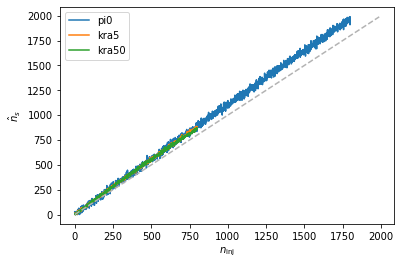

In [14]:
# load data from signal trials
df_ns_bias = {}

fig, ax = plt.subplots()
max_val = 0.
for key in ['pi0', 'kra5', 'kra50']:
    df_ns_bias[key] = pd.read_csv(os.path.join(data_dir, 'ns_bias_{}.csv'.format(key)))
    
    # plot the ns-bias
    ax.plot(df_ns_bias[key]['n_inj'], df_ns_bias[key]['median_ns'], label=key)
    _max_val = np.max(df_ns_bias[key]['median_ns'])
    if _max_val > max_val:
        max_val = _max_val
    
ax.set_xlabel('$n_\mathrm{inj}$')
ax.set_ylabel('$\hat{n}_s$')
ax.plot((0., max_val), (0., max_val), ls='--', color='0.7')
ax.legend()


As seen above, a slight bias is visible: the fitted number of events $\hat{n}_s$ tend to overestimate the true injected number of events. We will correct for this bias in order to obtain a better estimate of the true number of signal events by defining a bias-correction function for each model, which we will save in the dictionary `bias_corr_func`.

In [15]:
bias_corr_func = {}
for key, bias_dict in df_ns_bias.items():
    # fit a spline function to the value pairs
    # we will use this later to bias-correct the best-fit ns
    sorted_idx = np.argsort(bias_dict['median_ns'])
    bias_corr_func[key] = UnivariateSpline(
        x=bias_dict['median_ns'][sorted_idx], 
        y=bias_dict['n_inj'][sorted_idx], 
        # choose an appropriate smoothing for the spline
        s=len(bias_dict['n_inj'])*500,
    )
    print('Model: {}'.format(key))
    print('   Best-fit ns: {:3.1f}'.format(res_dict[key]['ns']))
    print('   Bias corrected ns: {:3.1f}'.format(bias_corr_func[key](res_dict[key]['ns'])))
    

Model: pi0
   Best-fit ns: 748.0
   Bias corrected ns: 671.1
Model: kra5
   Best-fit ns: 275.6
   Bias corrected ns: 242.9
Model: kra50
   Best-fit ns: 211.1
   Bias corrected ns: 184.8


Now we can convert the bias-corrected $\hat{n}_s$ to the corresponding flux in terms of $E^2 \frac{dN}{dE}$ at 100 TeV in units of $\mathrm{TeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$ for the $\pi^ 0$ model.

In [16]:
E2dNdE_pi0 = acceptance_correct_pi0(
    ns=bias_corr_func['pi0'](res_dict['pi0']['ns']),
    template=template_pi0,
    eff_area=effa_values,
    sindec_bins=effa_bins_sindec,
    energy_bins=effa_bins_energy,
)
print('pi0 model flux: {:3.2e}'.format(E2dNdE_pi0))

pi0 model flux: 2.17e-11


And in terms of model normalization for the KRA-$\gamma$ models:

In [17]:
model_norm_kra5 = acceptance_correct_kra(
    ns=bias_corr_func['kra5'](res_dict['kra5']['ns']),
    template=template_kra5,
    template_e_bin_edges=template_ebins5_ext,
    eff_area=effa_values,
    sindec_bins=effa_bins_sindec,
    energy_bins=effa_bins_energy,
)

model_norm_kra50 = acceptance_correct_kra(
    ns=bias_corr_func['kra50'](res_dict['kra50']['ns']),
    template=template_kra50,
    template_e_bin_edges=template_ebins50_ext,
    eff_area=effa_values,
    sindec_bins=effa_bins_sindec,
    energy_bins=effa_bins_energy,
)

print('Model normalization for KRA-gamma 5PeV model: {:3.2f}'.format(model_norm_kra5))
print('Model normalization for KRA-gamma 50PeV model: {:3.2f}'.format(model_norm_kra50))


Model normalization for KRA-gamma 5PeV model: 0.55
Model normalization for KRA-gamma 50PeV model: 0.37


The remaining <1% difference to the flux values stated in the paper is due to the necessary discretization of the effective area, while the analysis directly uses MC simulation.

## Plot flux (simplified version of Figure 5)

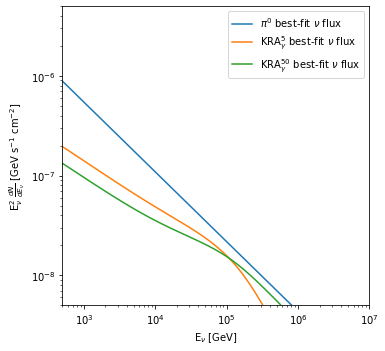

In [18]:
def powerlaw(energy, E2dNdE_at_100TeV, gamma=2.7):
    """Powerlaw flux

    Parameters
    ----------
    energy : array_like
        The energy in GeV at which to evaluate the powerlaw flux.
    E2dNdE_at_100TeV : array_like
        The powerlaw normalization in terms of E^2 dN/dE at 100 TeV
        in units of TeV^-1 cm^-2 s^-1.
    gamma : float, optional
        The spectral index.

    Returns
    -------
    array_like
        The powerlaw flux evaluated at the provided energies in terms
        of E^2 dN/dE in units of GeV^-1 cm^-2 s^-1.
    """
    e0 = 1e5  # 100 TeV

    # get normalization in dN/dE in units of GeV^-1 cm^-2 s^-1
    norm = E2dNdE_at_100TeV / (e0)**2 * 1e3
    dNdE = norm * (energy/e0)**(-gamma)
    return dNdE * energy**2

def plot_kra_flux(ax, template, bin_edges, model_norm=1., **kwargs):
    """Plot the KRA-gamma flux to a given axis.
    
    Parameters
    ----------
    ax : axis
        The matplotlib figure axis to which the flux will be plotted.
    template : array_like
        The model template binned over the sky and energy range in units
        of GeV^-1 * sr^-1 * s^-1 * cm^-2.
        Shape: [n_pix, n_bins]
    bin_edges : array_like
        The bin edges that define the energy bins of the model template.
        Shape: [n_bins + 1]
    model_norm : float, optional
        The model normalization to shift the nominal template flux by.
    **kwargs
        Keyword arguments passed on to ax.plot().
    """
    npix = len(template)
    nside = hp.npix2nside(npix)
    pixarea = hp.nside2pixarea(nside)
    
    # template provides all-flavor flux in
    # units of GeV^-1 * sr^-1 * s^-1 * cm^-2
    # integrate over the sky to obtain units of GeV^-1 * s^-1 * cm^-2
    # shape: [n_bins]
    flux = np.sum(template, axis=0) * pixarea
    
    # divide by three to obtain per-flavor neutrino flux
    flux /= 3.
    
    # scale by provided model normalization
    flux *= model_norm

    # compute bin centers
    # (Note that this does not account for energy spectrum within a bin)
    bin_mids = bin_edges[:-1] + 0.5*np.diff(bin_edges)
    
    # convert to E^2 * dN/dE in units of GeV * s^-1 * cm^-2
    E2_flux = bin_mids**2 * flux

    # plot flux
    ax.plot(bin_mids, E2_flux, **kwargs)


energies = np.logspace(np.log10(500), 6.5, 100)
fig, ax = plt.subplots(figsize=(5.5,5.5))
ax.plot(energies, powerlaw(energies, E2dNdE_at_100TeV=E2dNdE_pi0), label=r'$\pi^0$ best-fit $\nu$ flux')
plot_kra_flux(
    ax=ax, 
    template=template_kra5, 
    bin_edges=template_ebins5_ext, 
    model_norm=model_norm_kra5, 
    label=r'KRA$_\gamma^5$ best-fit $\nu$ flux',
)
plot_kra_flux(
    ax=ax, 
    template=template_kra50, 
    bin_edges=template_ebins50_ext, 
    model_norm=model_norm_kra50, 
    label=r'KRA$_\gamma^{50}$ best-fit $\nu$ flux',
)
ax.set_ylabel(r'E$_{\nu}^2$ $\frac{dN}{dE_\nu}$ [GeV s$^{-1}$ cm$^{-2}$]')
ax.set_xlabel(R'E$_\nu$ [GeV]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(500, 1e7)
ax.set_ylim(5e-9, 5e-6)
ax.legend()
